# Hierarchical Risk Parity

The key idea of hierarchical risk parity is to use hierarchical clustering on the covariance matrix to be able to group assets with similar correlations together and reduce the number of degrees of freedom by only considering 'similar' assets as substitutes when constructing the portfolio.

## Imports & Settings

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from datetime import date, timedelta, datetime

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_var_pf(cov_)
    return (w_ @ cov_ @ w_).item()

In [3]:
def get_hrp_allocation(cov, tickers):
    """Compute top-down HRP weights"""

    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets

    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]
        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(cov, cluster0)
            cluster1_var = get_cluster_var(cov, cluster1)

            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler
    return weights

In [4]:
def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [5]:
def get_inverse_var_pf(cov, **kargs):
    """Compute the inverse-variance portfolio""" 
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

In [6]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation; 
        0 <= d[i,j] <= 1""" 
    return np.sqrt((1 - corr) / 2)

In [7]:
sns.set_style('whitegrid')
np.random.seed(42)
idx = pd.IndexSlice

In [8]:
hrp_allocation_final = pd.DataFrame()

In [9]:
inicio_carteira_valor = '2018-08-01'

In [10]:
carteira = pd.read_csv('CARTEIRA VALOR2.csv')
carteira['date_start'] = pd.to_datetime(carteira['date_start']) # converte a data do formato do excel para python
carteira['data_end'] = pd.to_datetime(carteira['data_end'])
carteira.to_csv("temp.csv") # faço esse procedimento para evitar o problema nas datas abaixo
carteira = pd.read_csv("temp.csv")#, skiprows=[0])
carteira = carteira[(carteira.date_start >= inicio_carteira_valor)]
df_dates = carteira.data_end.unique().tolist()

In [11]:
indices = pd.read_csv('indices.csv')
indices['date'] = pd.to_datetime(indices['date']) # converte a data do formato do excel para python
indices.to_csv("temp_indices.csv") # faço esse procedimento para evitar o problema nas datas abaixo
indices = pd.read_csv("temp_indices.csv")#, skiprows=[0])
indices = indices[(indices.date >= inicio_carteira_valor)]
indices = indices.filter(['date','ibov','cdi_acumulado'])
indices['date'] = pd.to_datetime(indices['date']) # converte a data do formato do excel para python
indices['ibov_acu'] = (((1+indices['ibov']).cumprod()-1)*100)/100
indices['cdi_acu'] = (((1+indices['cdi_acumulado']).cumprod()-1)*100)/100
#indices.to_csv('indices_acu.csv')


/home/erasmo/anaconda3/envs/base37/lib/python3.7/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


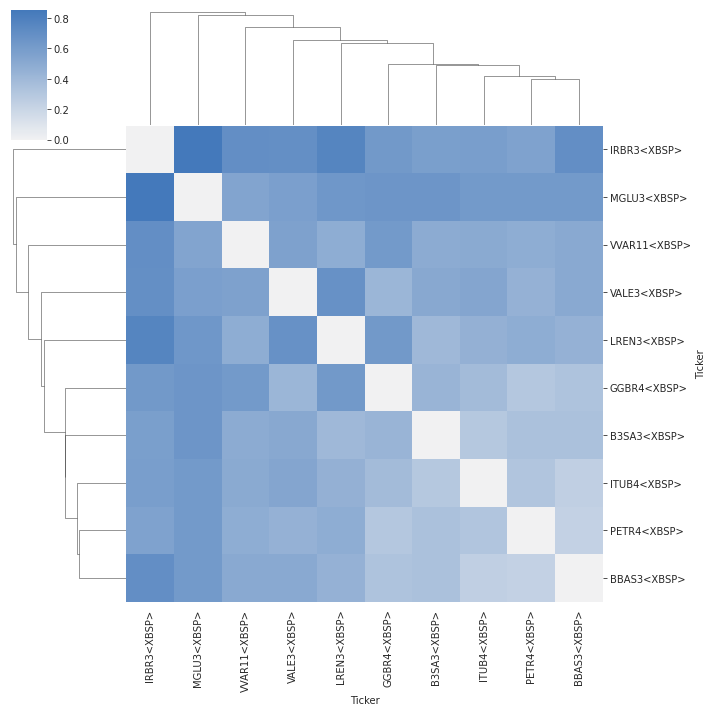

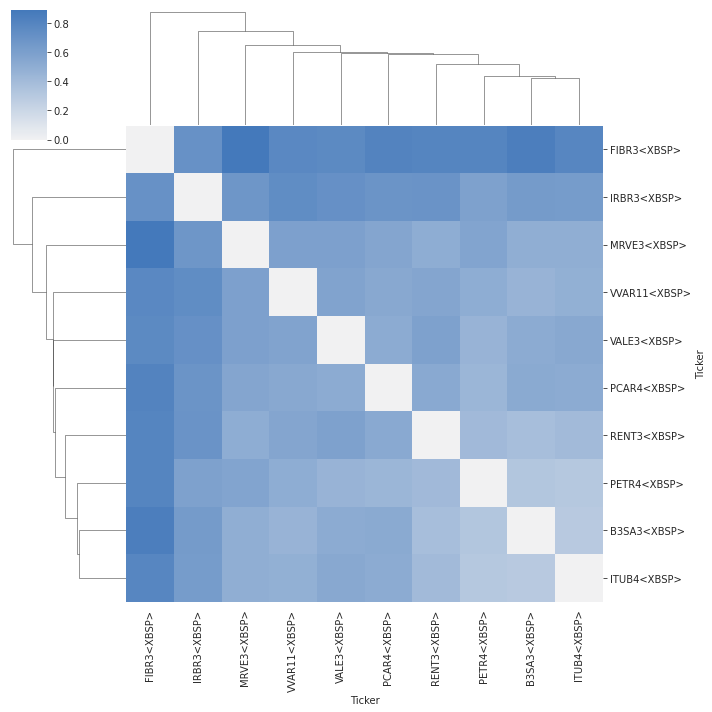

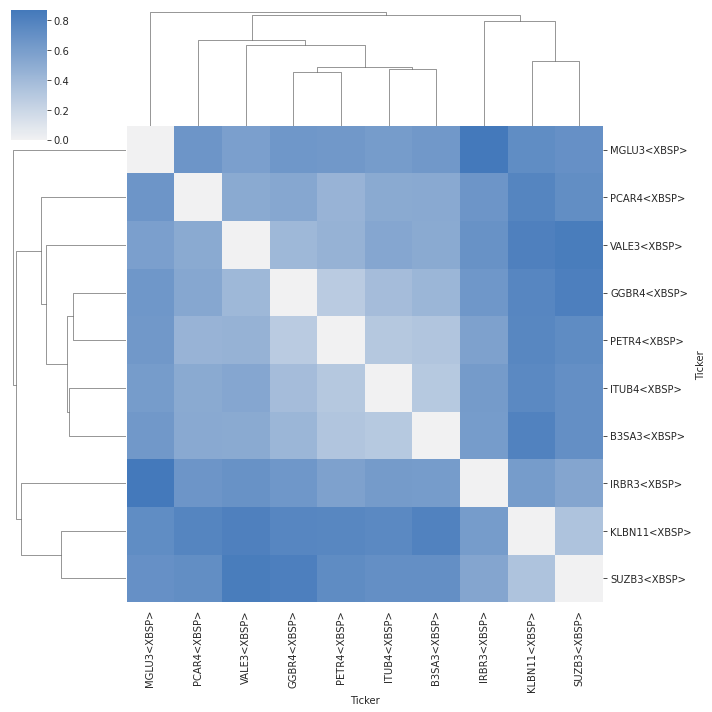

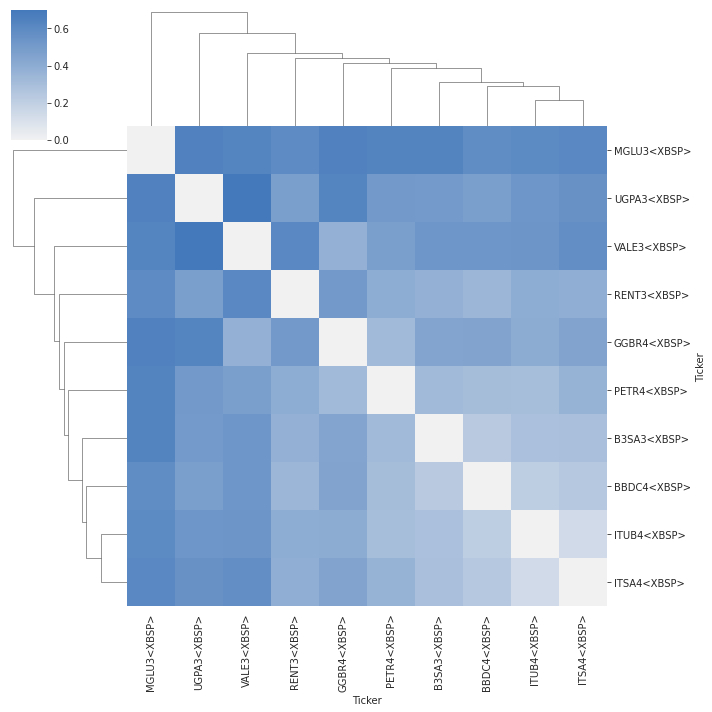

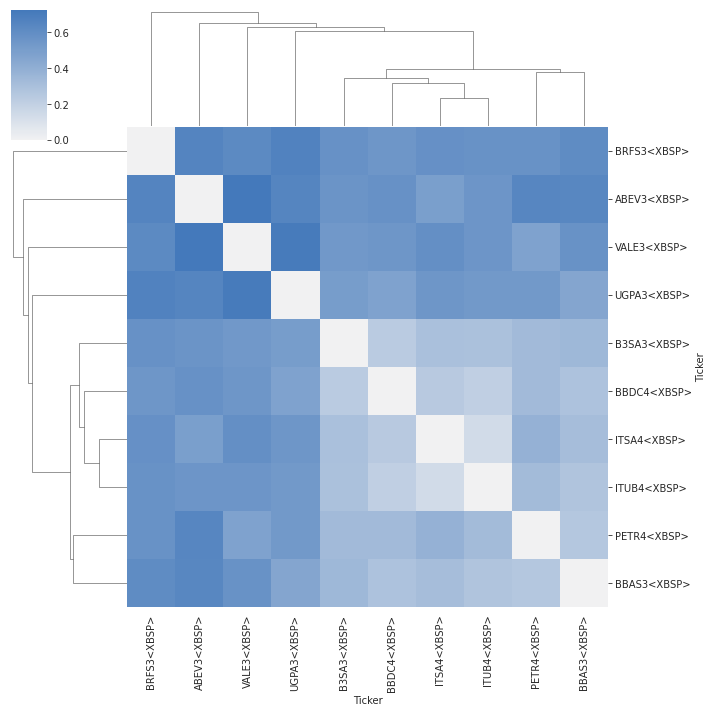

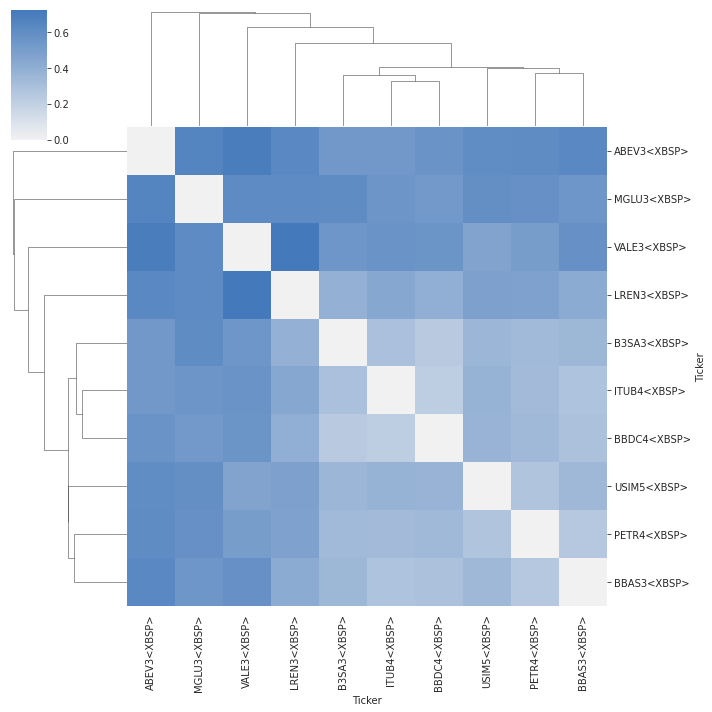

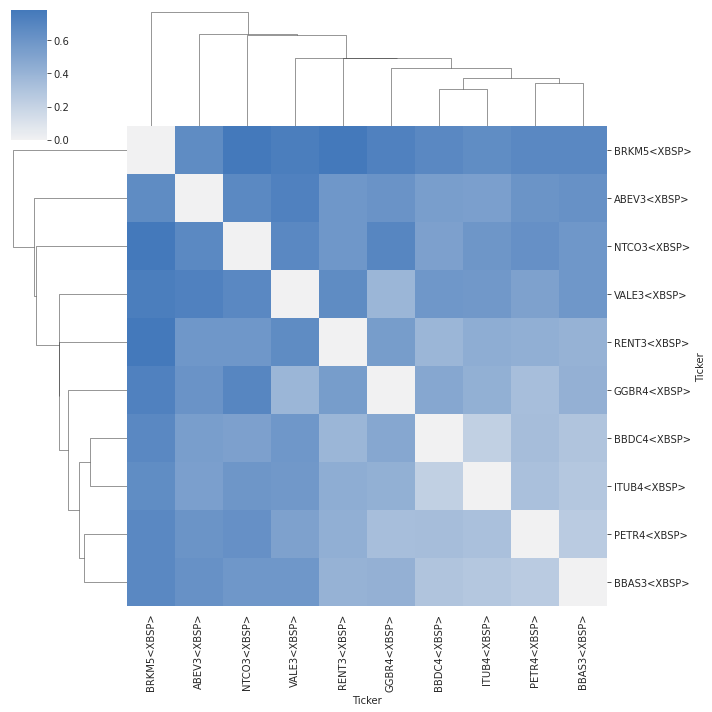

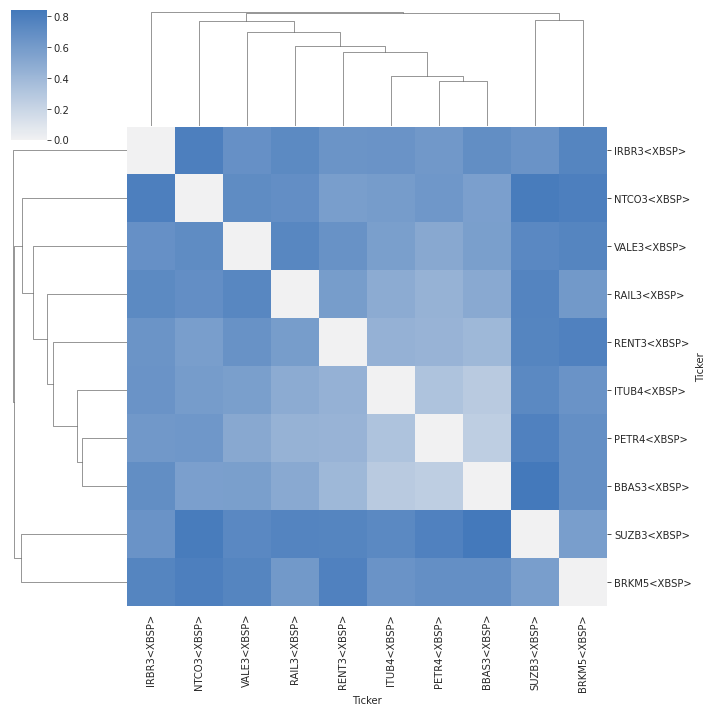

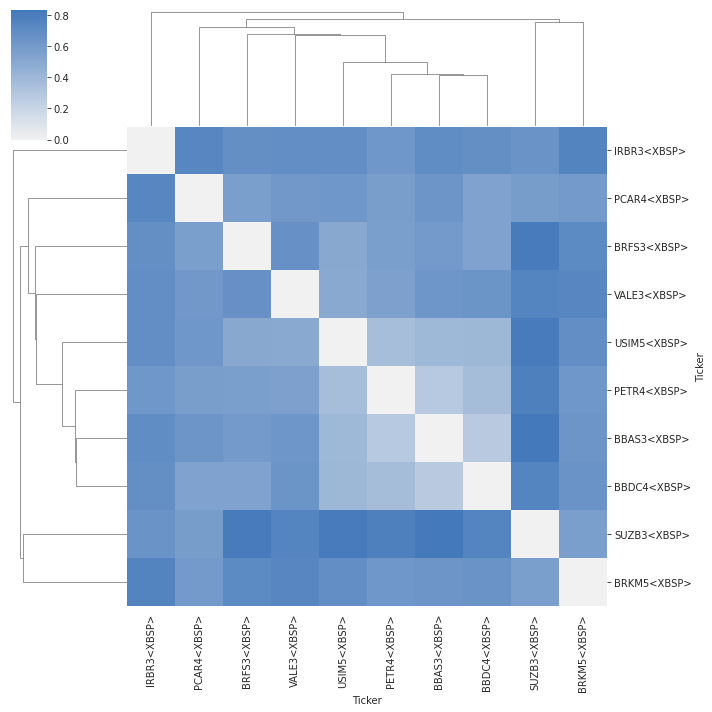

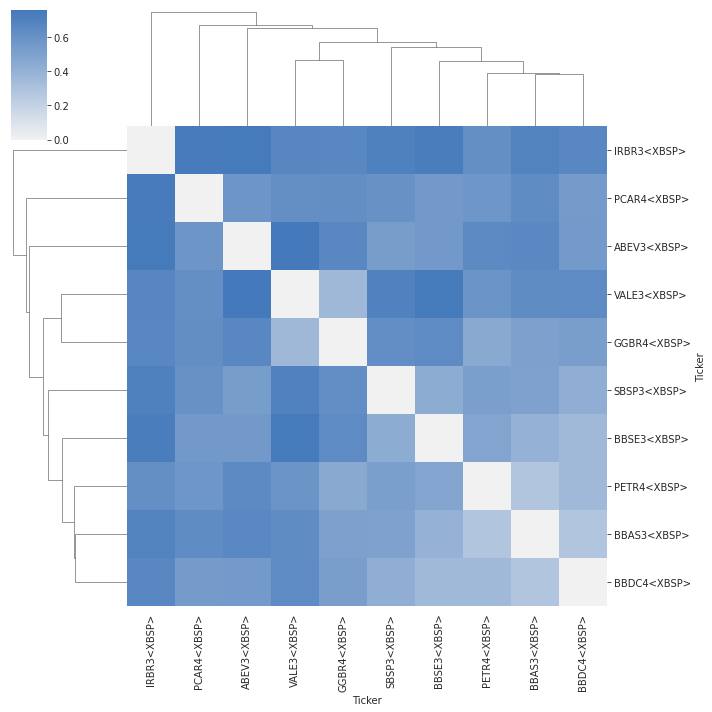

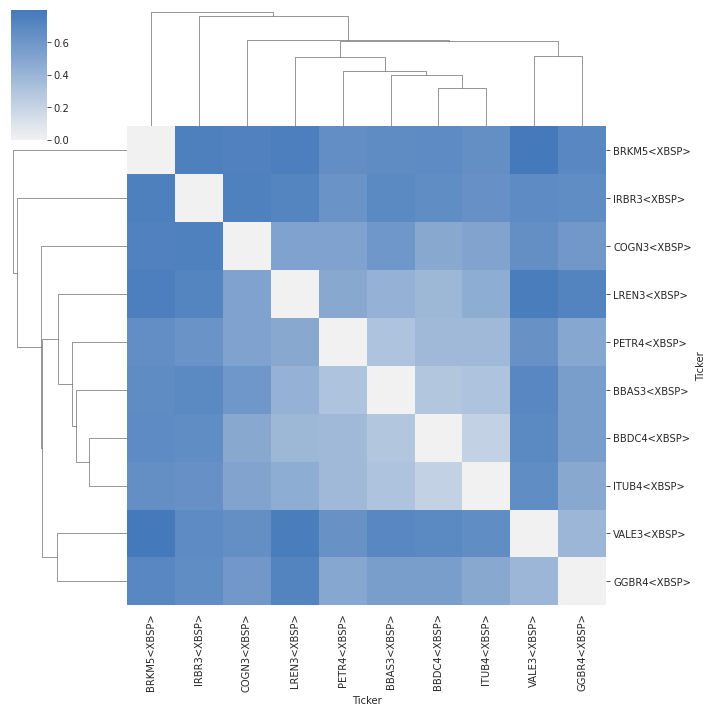

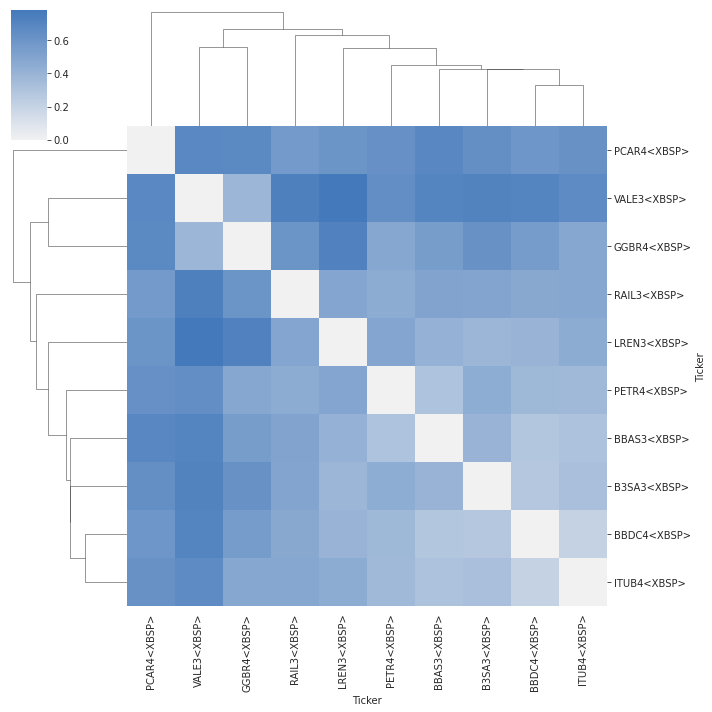

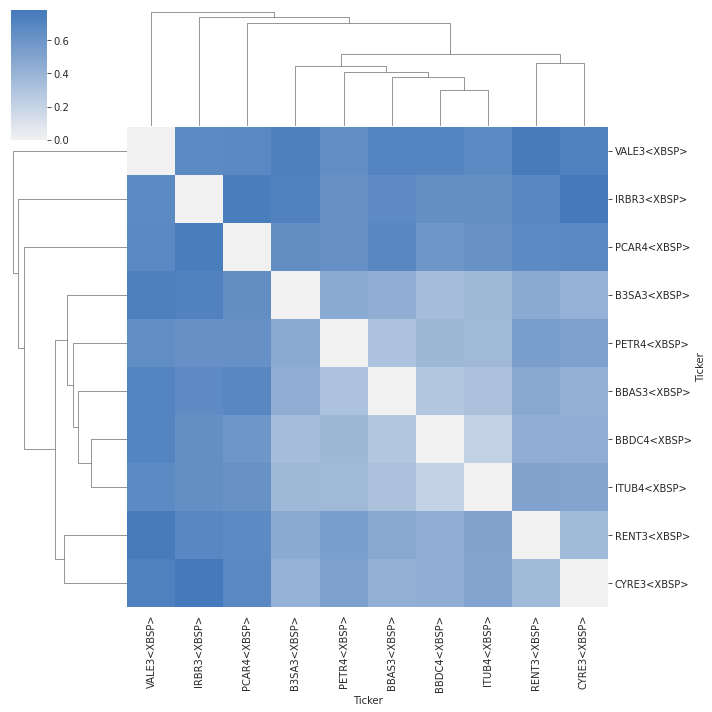

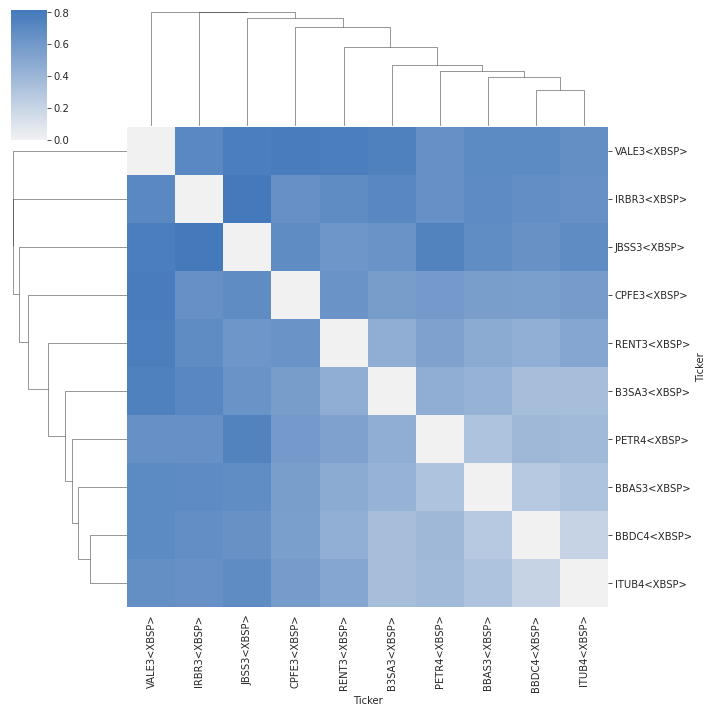

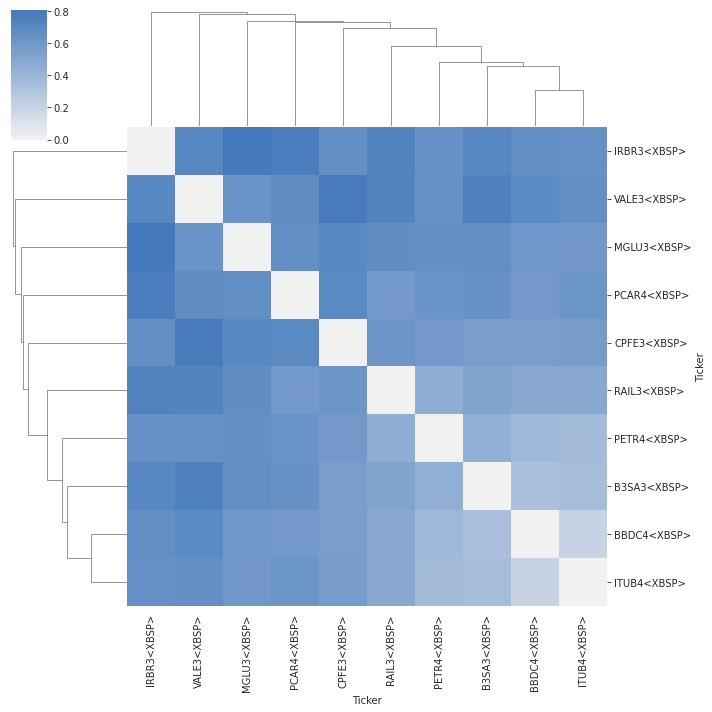

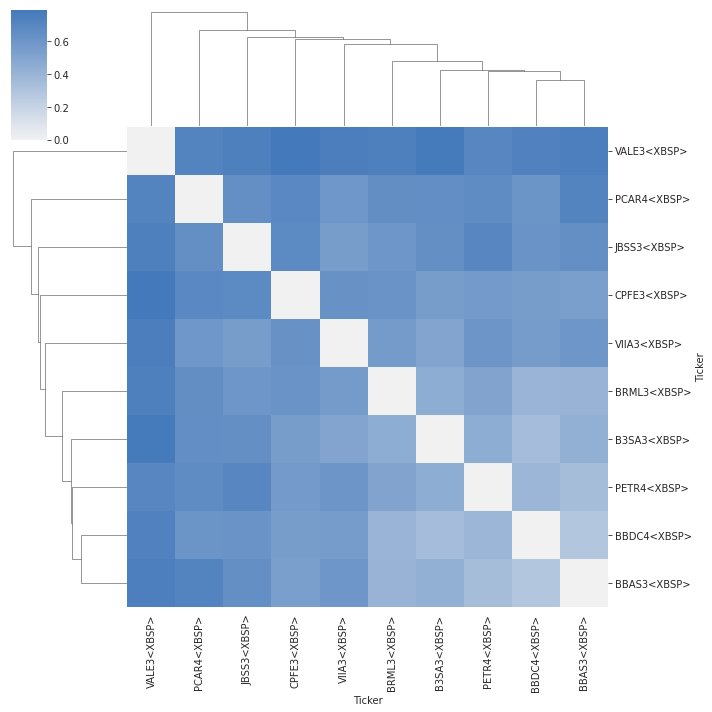

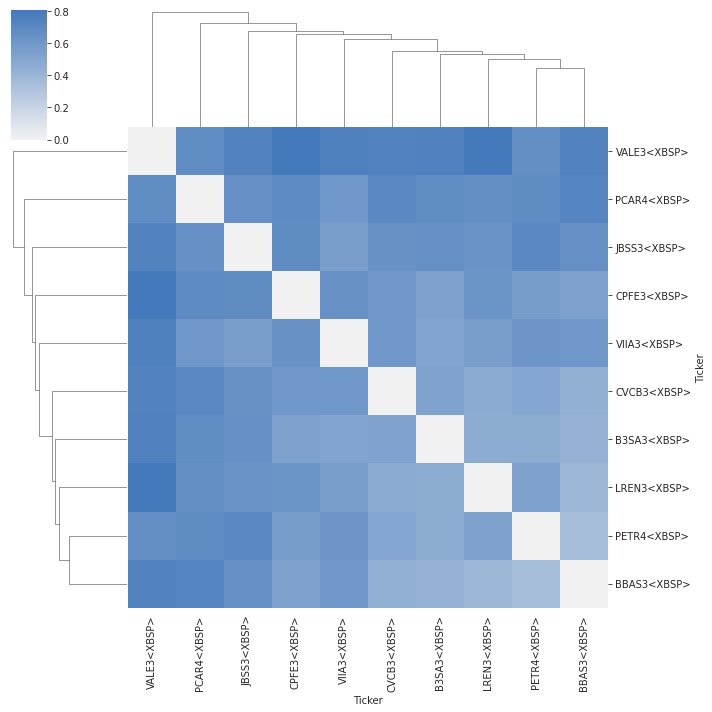

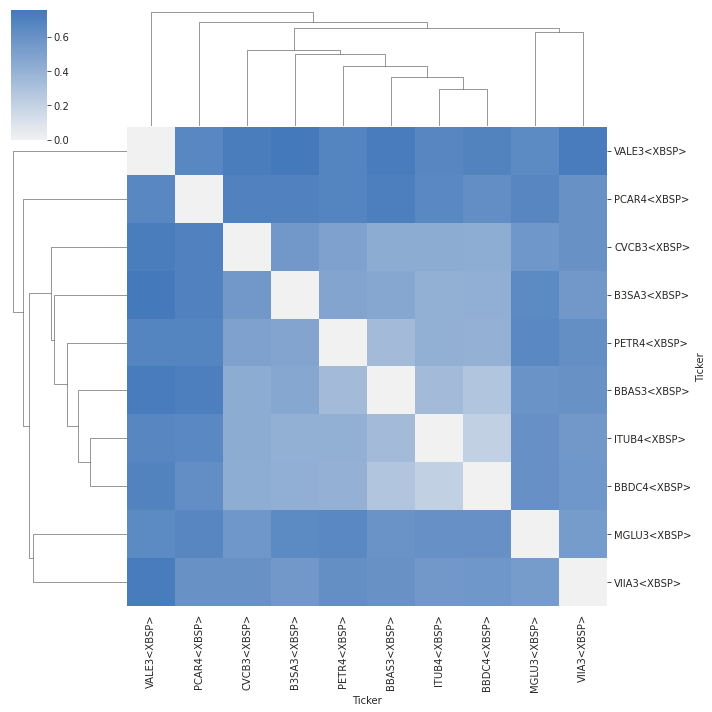

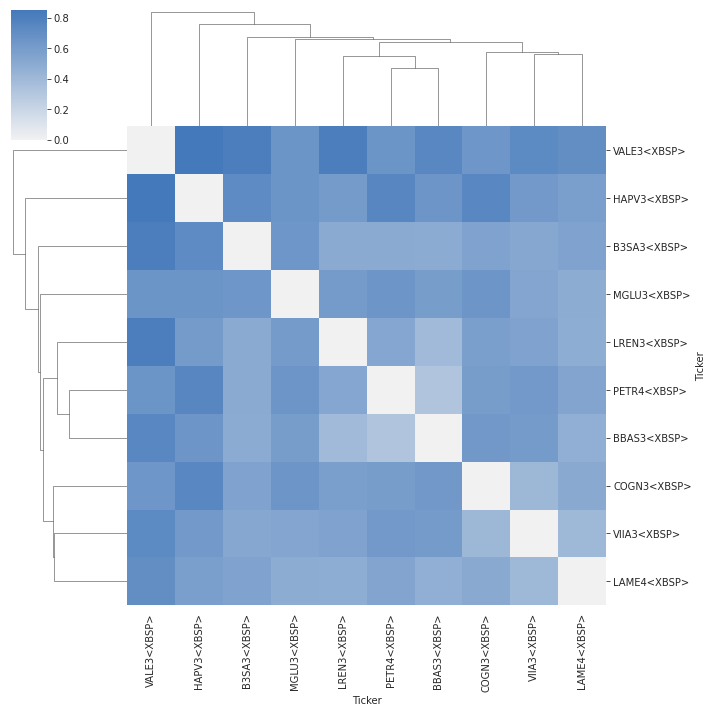

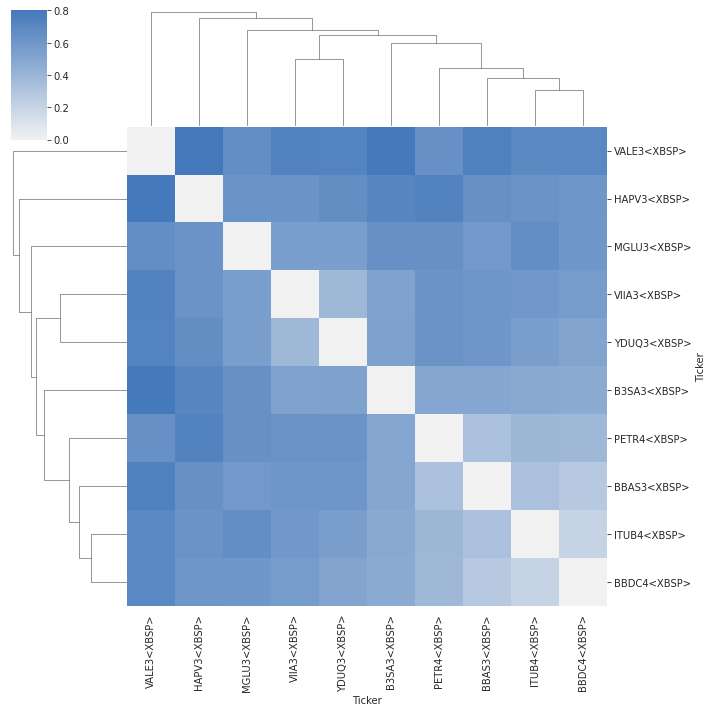

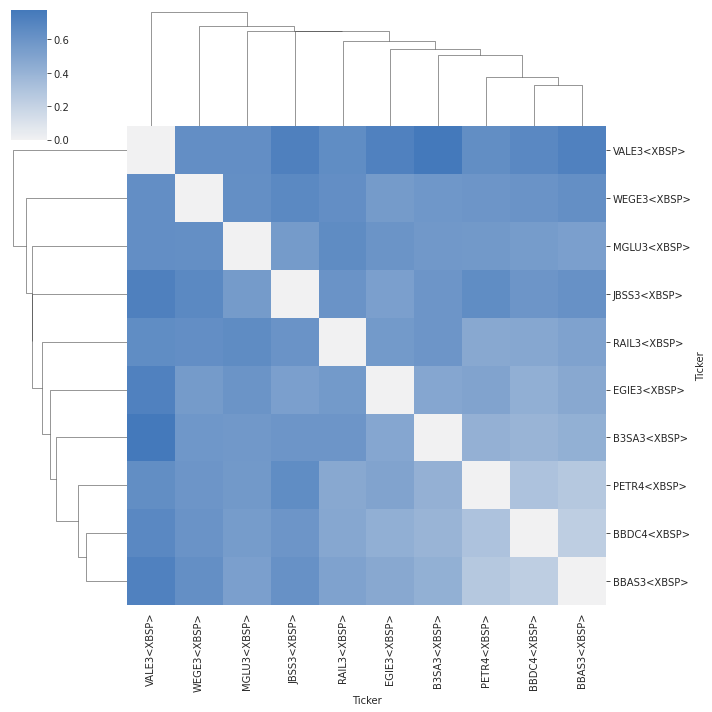

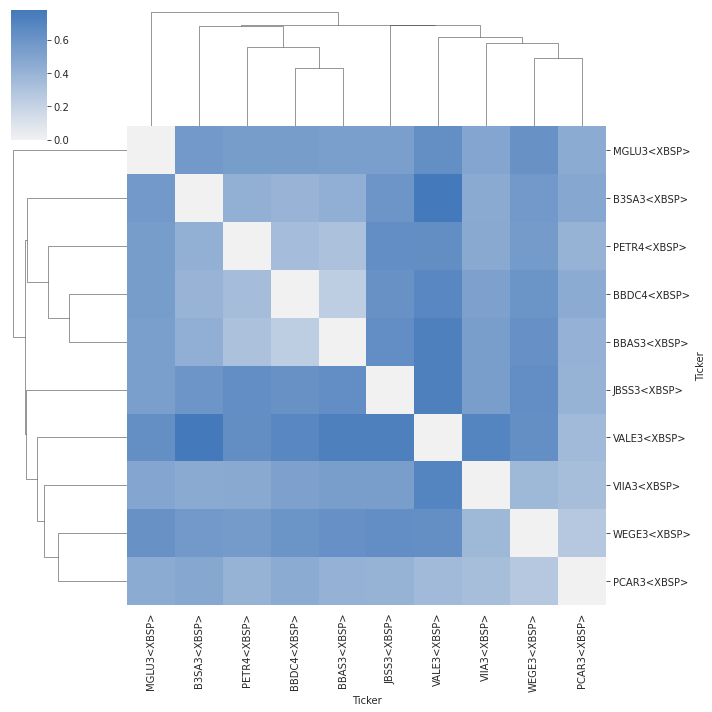

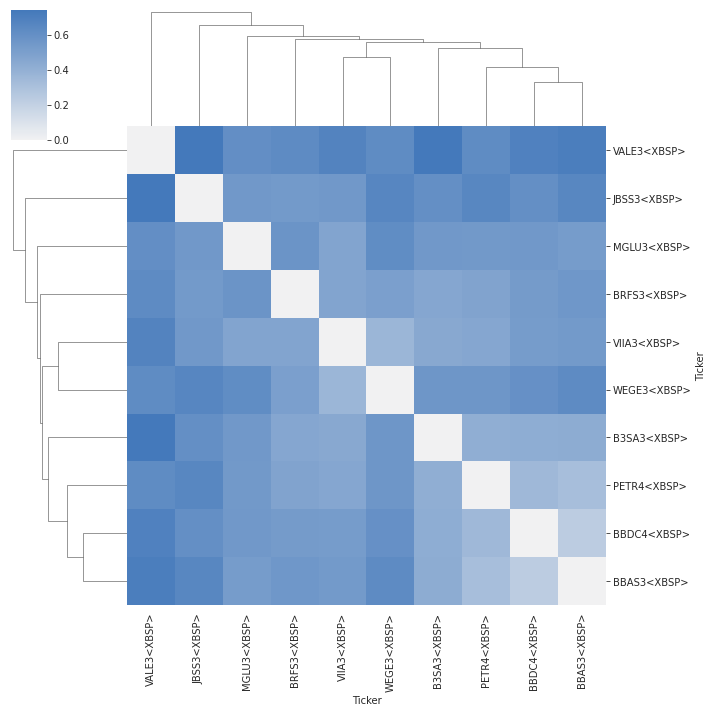

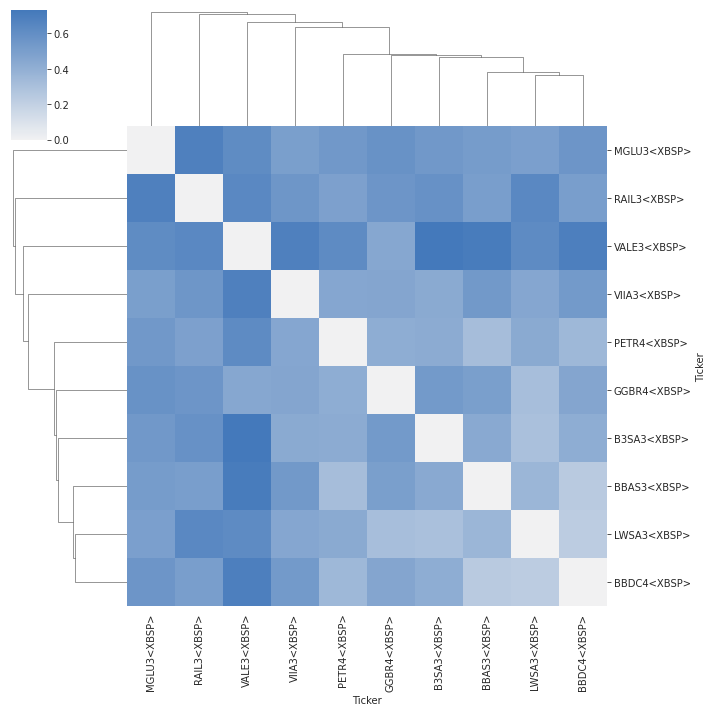

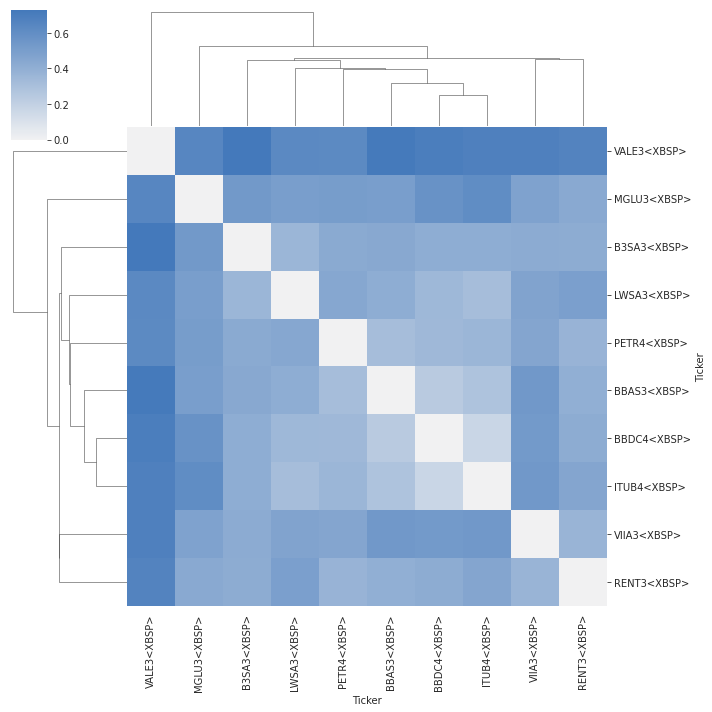

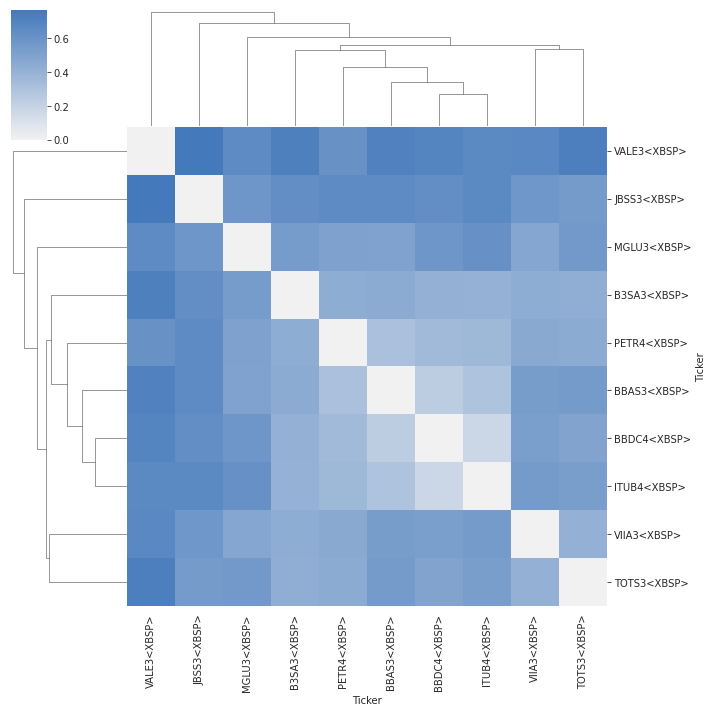

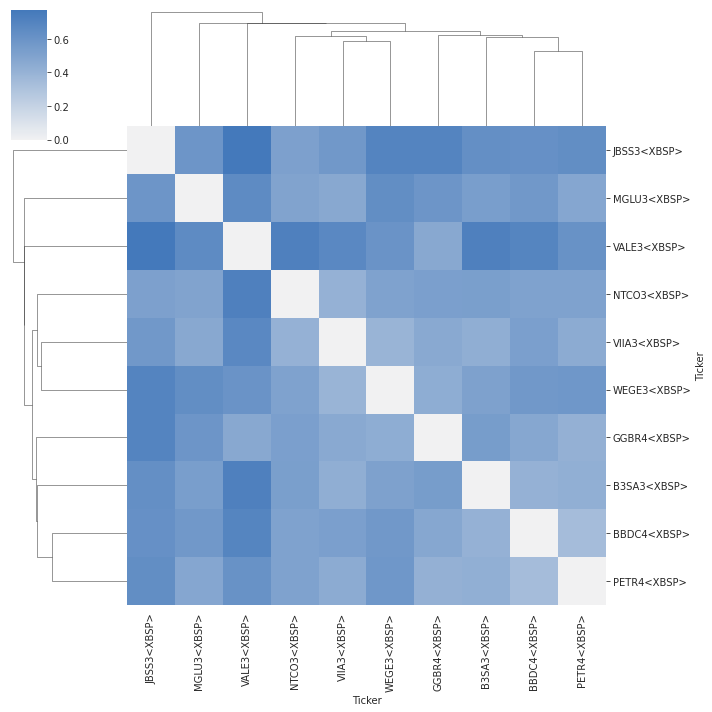

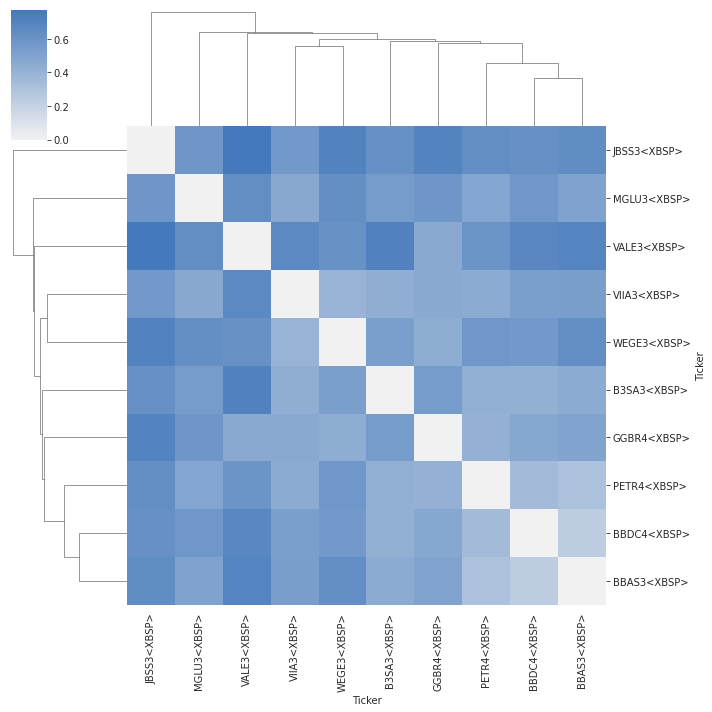

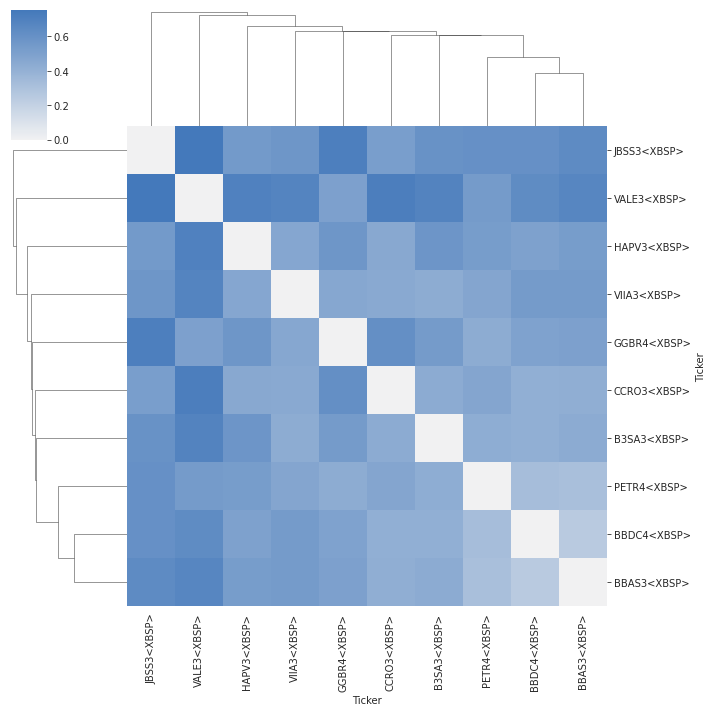

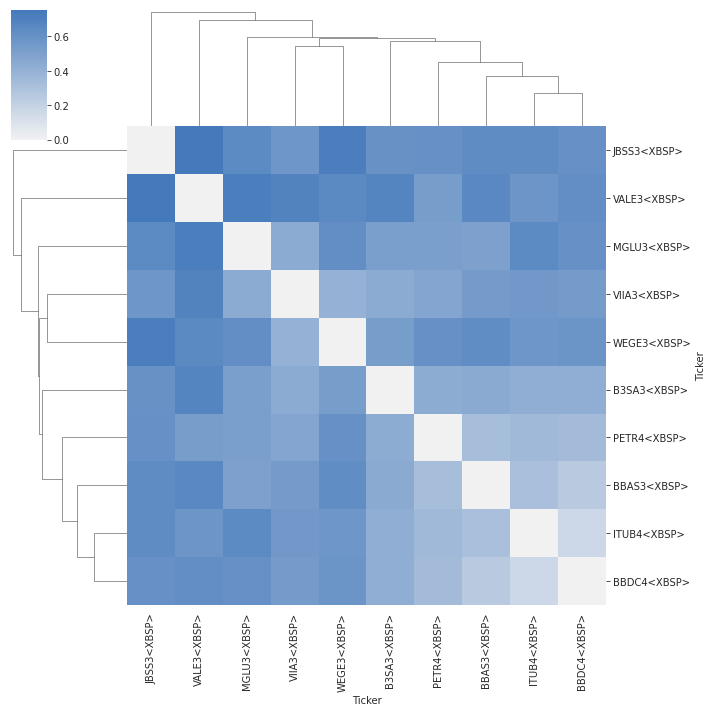

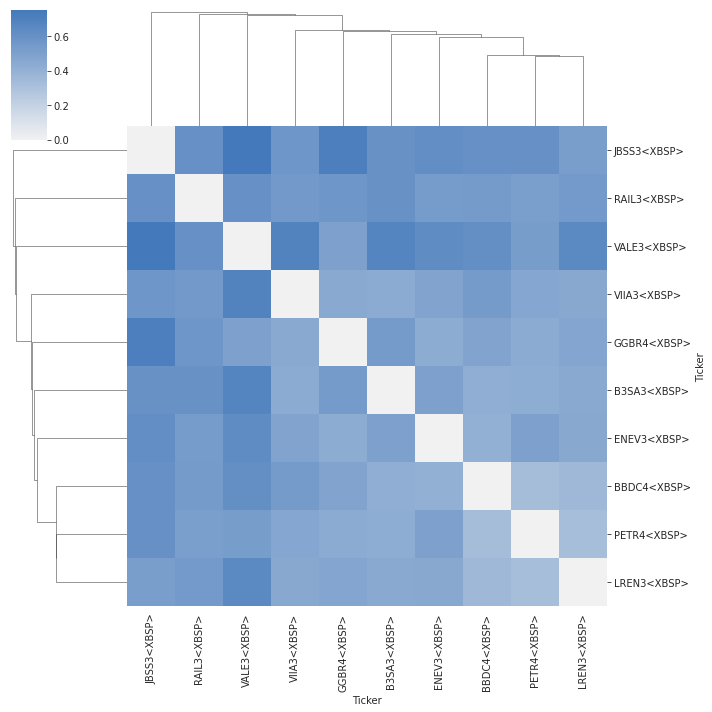

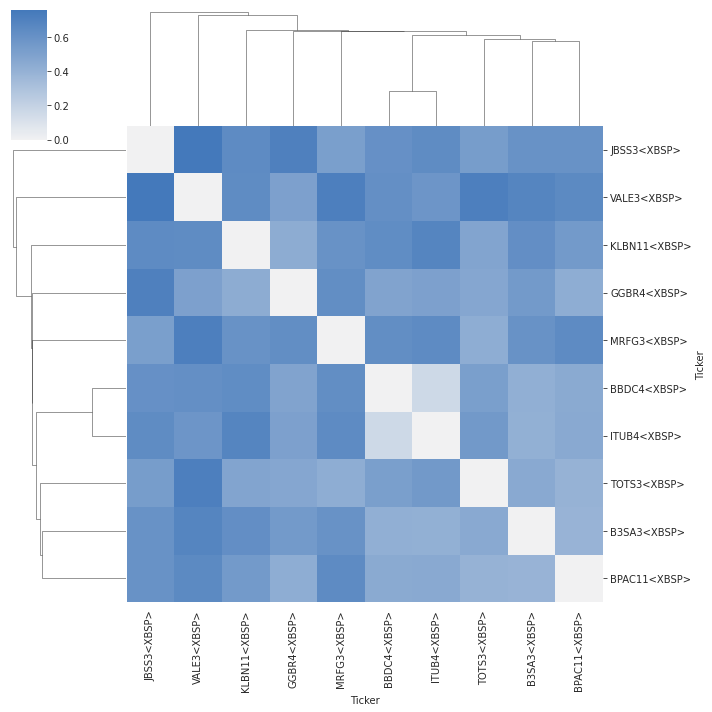

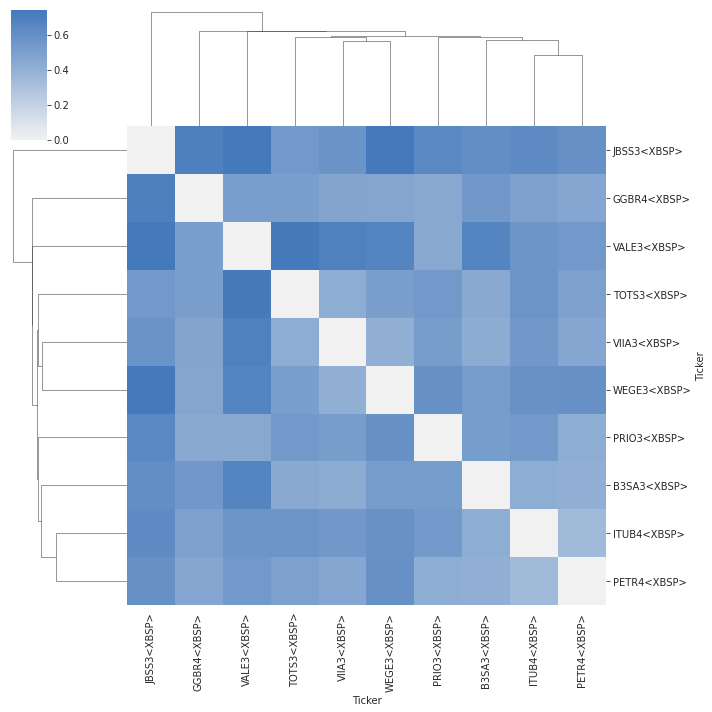

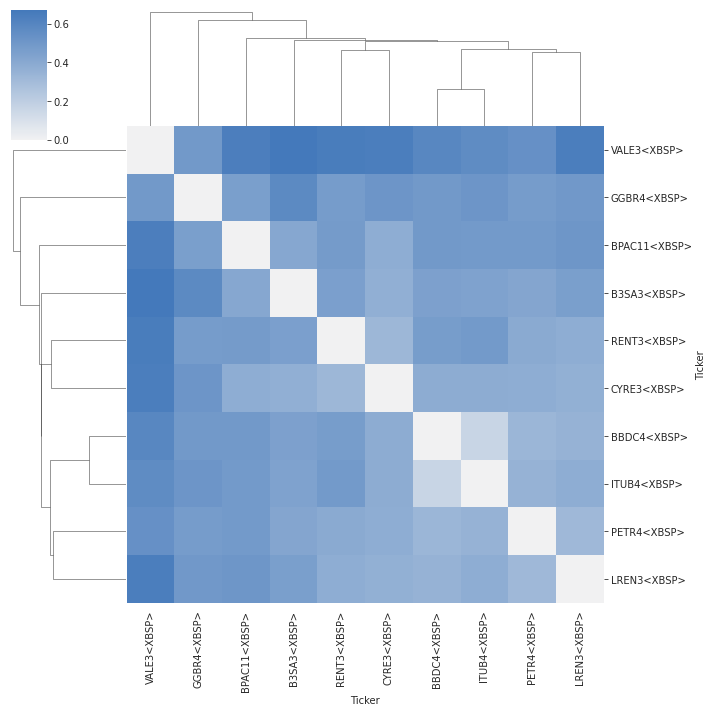

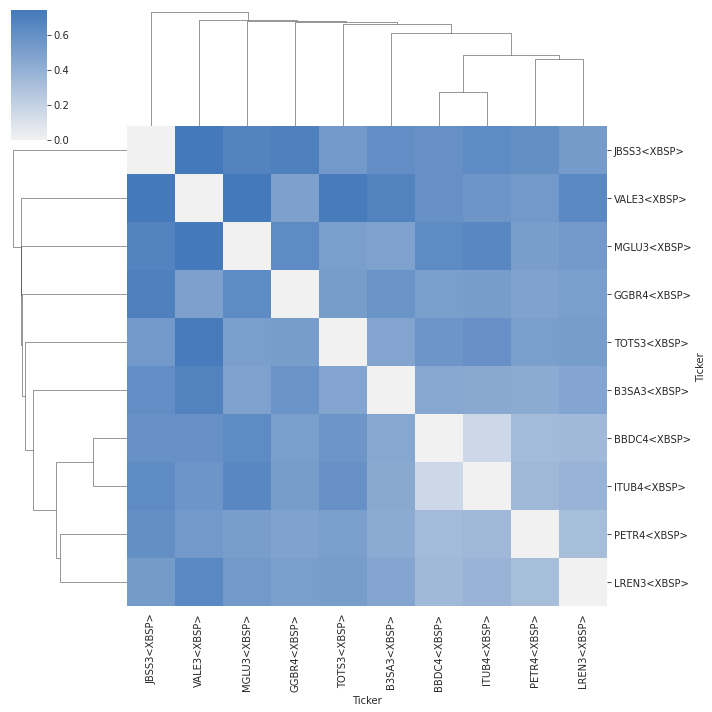

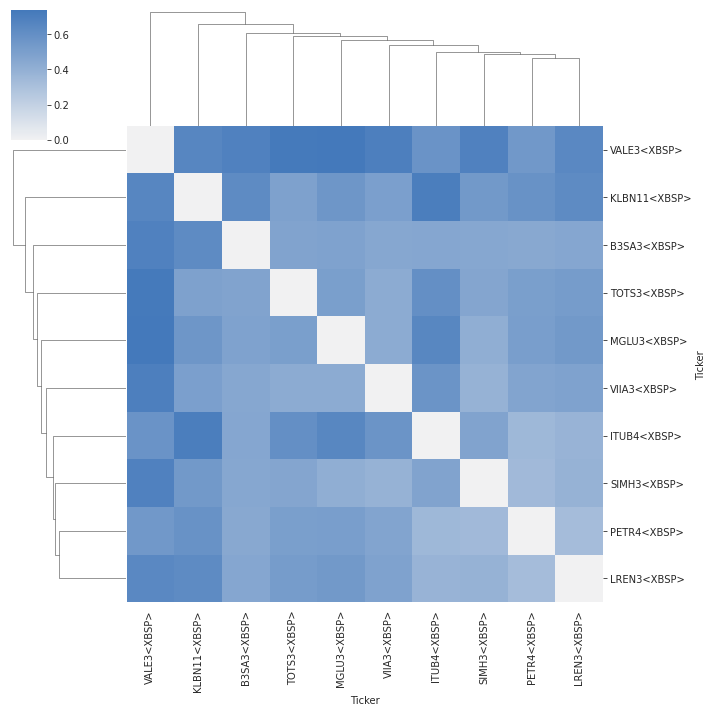

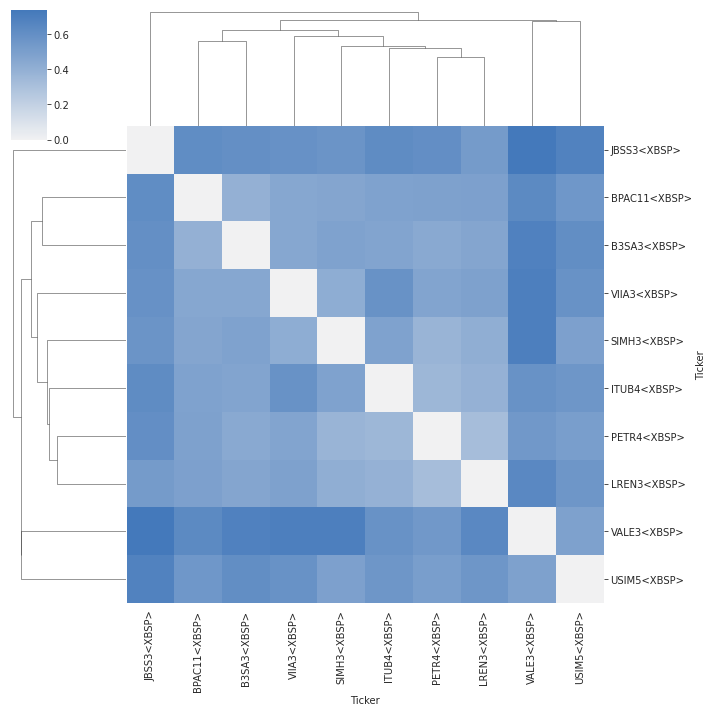

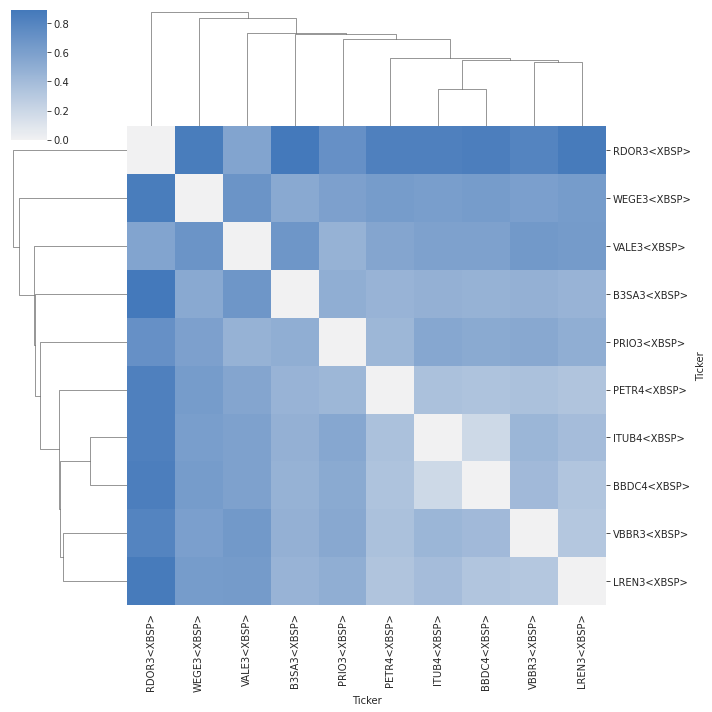

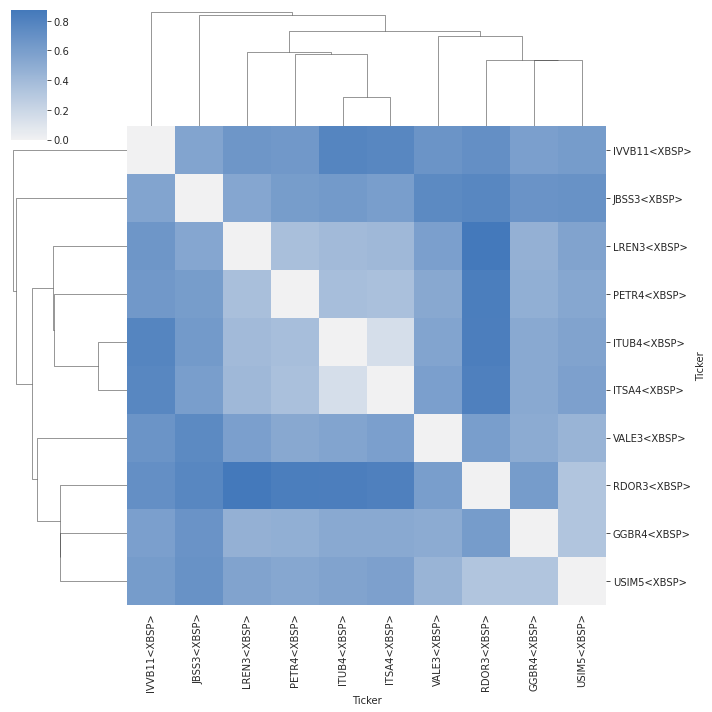

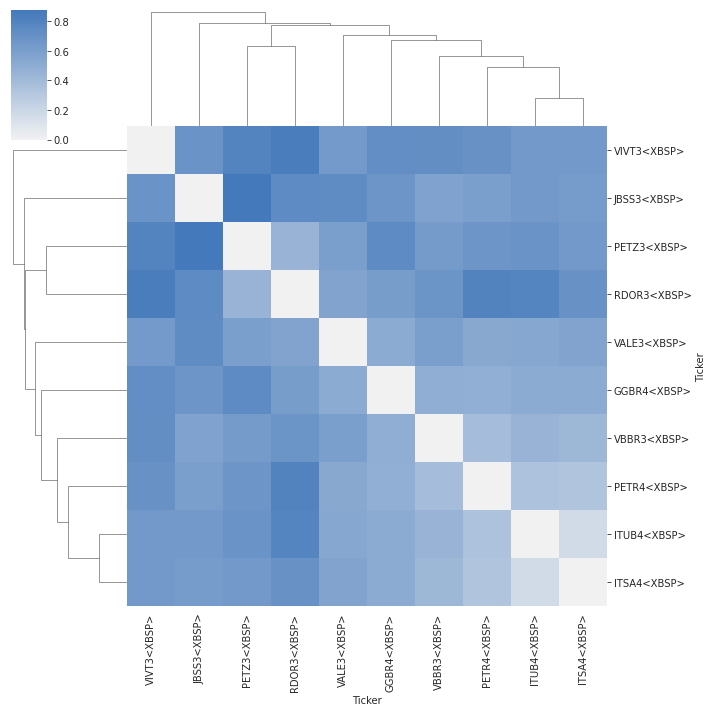

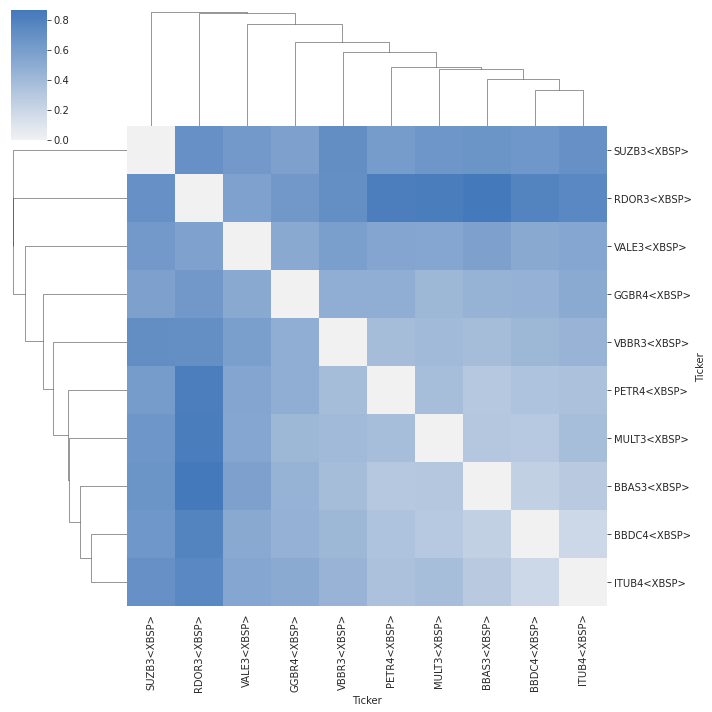

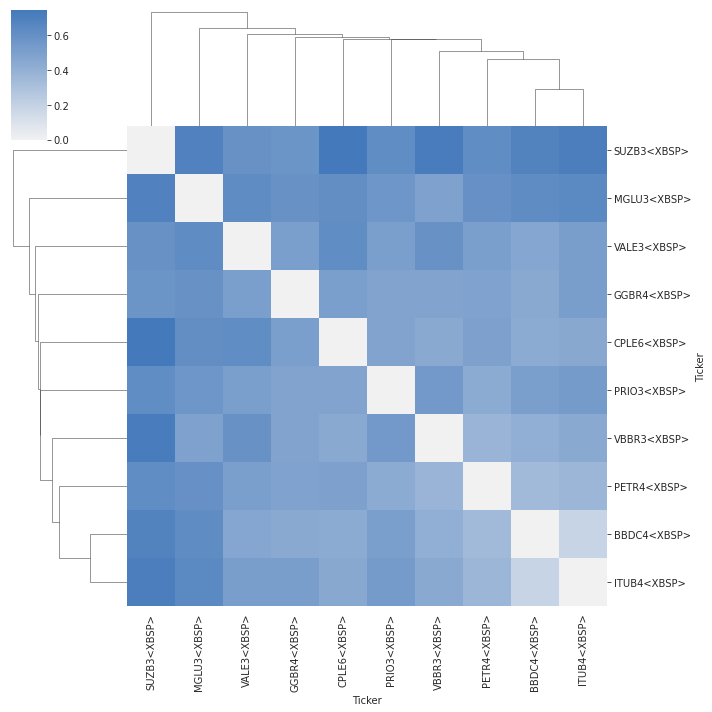

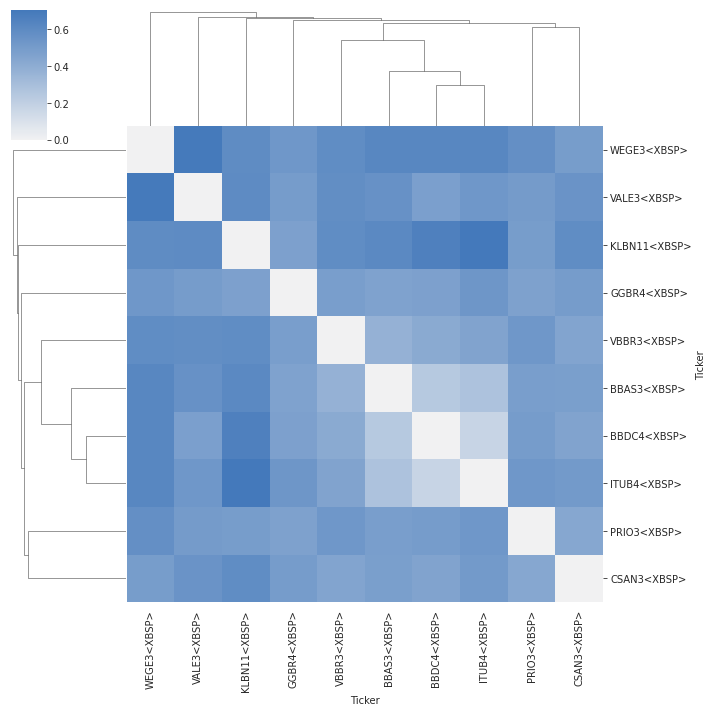

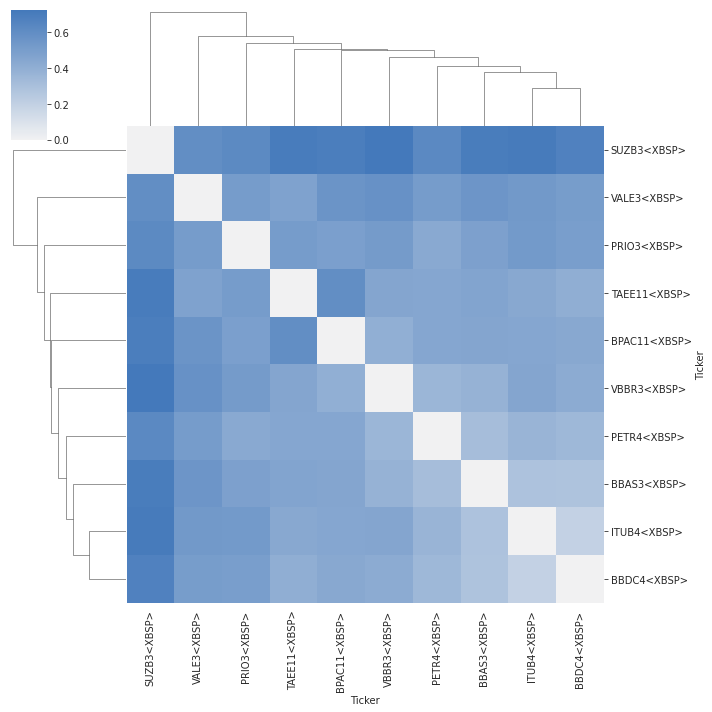

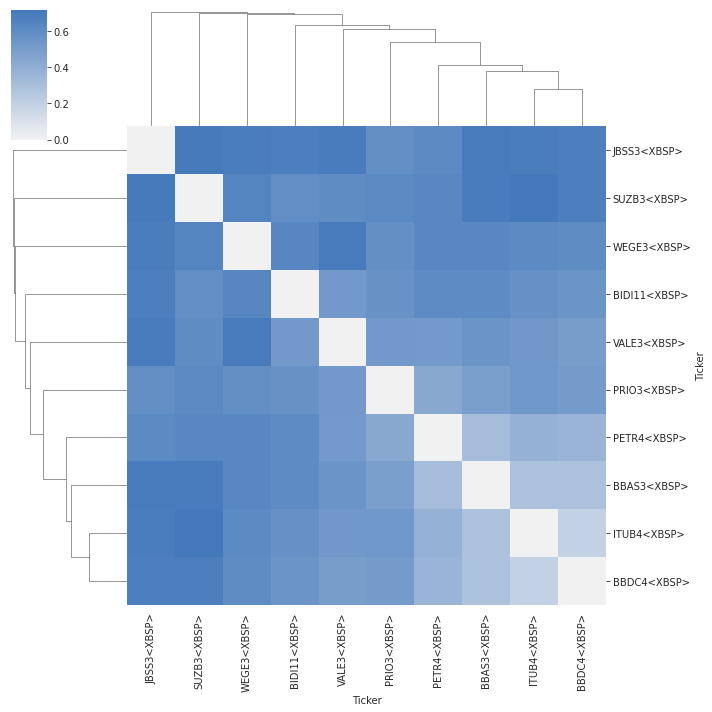

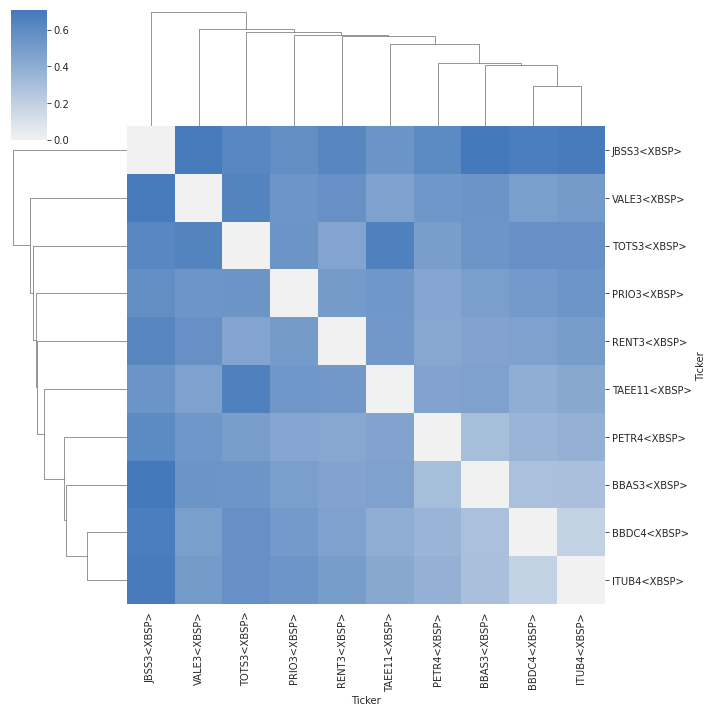

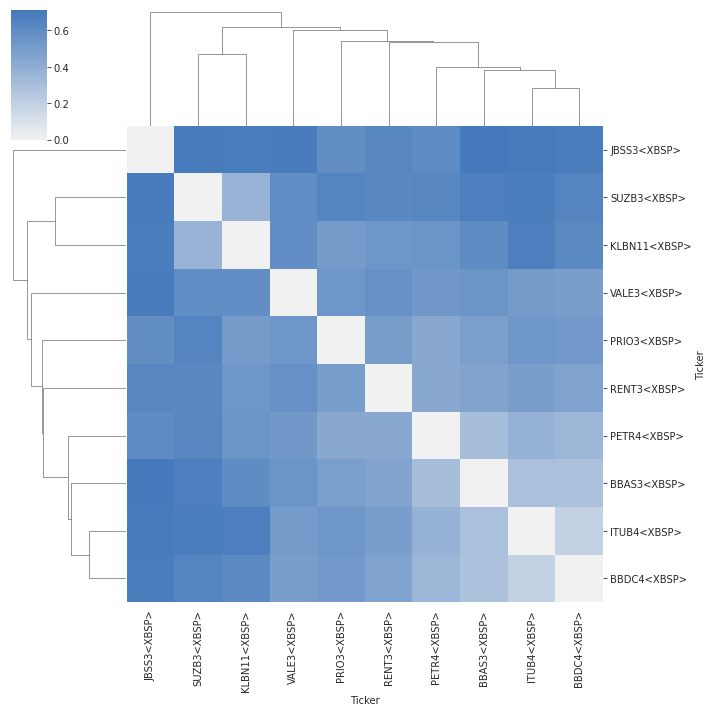

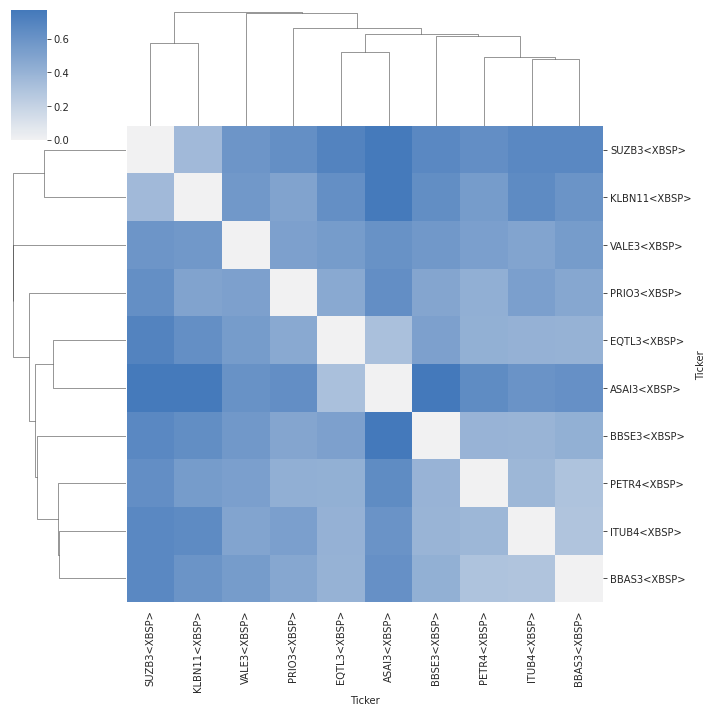

In [12]:
for x in df_dates: 
    
    YEAR = 365
    
    end=x
    start = pd.to_datetime(end) - timedelta(days=YEAR*3)
    start = start.strftime("%Y-%m-%d")    
       
    prices = pd.read_csv('HIST CARTEIRA VALOR2.csv')
    prices = prices.dropna()
    prices['date_start'] = pd.to_datetime(prices['date_start']) # converte a data
    prices['data_end'] = pd.to_datetime(prices['data_end'])
    prices.to_csv("temp2.csv") # faço esse procedimento para evitar o problema nas datas abaixo
    prices = pd.read_csv("temp2.csv")#, skiprows=[0])
    prices = prices.drop_duplicates()
    
    prices = prices[(prices.data_end >= start)]
    prices = prices[(prices.data_end < x)] #filtra periodo anterior a carteira para formação das matrizes
    
    prices = prices.filter(['ticker', 'data_end', 'ret'])
    prices = prices.drop_duplicates()
    prices = prices.set_index(['data_end', 'ticker']).unstack()
    prices.to_csv("prices.csv")
    prices = pd.read_csv("prices.csv", skiprows=[0])
    prices = prices.iloc[1: , :] #drop primeira linha
    
    carteira = pd.read_csv('temp.csv')
    carteira = carteira[(carteira.data_end==x)]
    carteira = carteira.set_index('ticker')
    carteira = carteira.index
    
    if len(carteira) > 1:
        monthly_returns = prices.filter(carteira)
        monthly_returns.columns.names = ['Ticker']

        cov = monthly_returns.cov()
        corr = monthly_returns.corr()
        corr.columns.names=['Ticker']

        cmap = sns.diverging_palette(10, 250, as_cmap=True)

        distance_matrix = get_distance_matrix(corr)
        linkage_matrix = linkage(squareform(distance_matrix), 'single')

        sorted_idx = quasi_diagonalize(linkage_matrix)

        clustergrid = sns.clustermap(distance_matrix, 
                                        method='single', 
                                       row_linkage=linkage_matrix, 
                                      col_linkage=linkage_matrix, 
                                     cmap=cmap, center=0);

        sorted_idx = clustergrid.dendrogram_row.reordered_ind
        sorted_tickers = corr.index[sorted_idx].tolist()
        hrp_allocation = get_hrp_allocation(cov, sorted_tickers)
        hrp_allocation = pd.DataFrame(hrp_allocation) ### transforma em df
        hrp_allocation = hrp_allocation.assign(date=x) ### insere a data da posição X no df
        hrp_allocation_final = hrp_allocation_final.append(hrp_allocation)
        #print(x)

In [13]:
START = '1900-01-01'
END = hrp_allocation_final.date.tail(1)[0]

In [14]:
hrp_allocation_final = hrp_allocation_final.rename(columns={0: 'pesos'})
hrp_allocation_final['date'] = pd.to_datetime(hrp_allocation_final['date']) # converte a data do formato do excel para python

In [15]:
hrp_allocation_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, IRBR3<XBSP> to BBAS3<XBSP>
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   pesos   480 non-null    float64       
 1   date    480 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.2+ KB


In [16]:
hrp_allocation_final.index.name = 'ticker' #### insere o nome para a primeira coluna
hrp_allocation_final = hrp_allocation_final.reset_index()
hrp_allocation_final['date'] = pd.to_datetime(hrp_allocation_final['date']) # converte a data
hrp_allocation_final = hrp_allocation_final.set_index(['date','ticker'])

In [17]:
prices = pd.read_csv('HIST CARTEIRA VALOR2.csv')
prices = prices.dropna()
prices['date_start'] = pd.to_datetime(prices['date_start']) # converte a data
prices['data_end'] = pd.to_datetime(prices['data_end'])
prices.to_csv("temp2.csv") # faço esse procedimento para evitar o problema nas datas abaixo
prices = pd.read_csv("temp2.csv")#, skiprows=[0])
prices = prices.drop_duplicates()

In [18]:
df_monthly_returns = prices.copy()
df_monthly_returns = df_monthly_returns[(df_monthly_returns.date_start >= '2010-01-01')]
df_monthly_returns  = df_monthly_returns.rename(columns={'data_end': 'date'})
df_monthly_returns['date'] = pd.to_datetime(df_monthly_returns['date']) # converte a data
df_monthly_returns = df_monthly_returns.filter(['ticker', 'date', 'ret']).set_index(['date','ticker'])
#df_monthly_returns

In [19]:
hrp = pd.merge(hrp_allocation_final, df_monthly_returns, how = 'left', on = ['date', 'ticker'])
#hrp.reset_index().to_csv('hrp.csv')
hrp = hrp.drop_duplicates()

In [20]:
hrp['retorno_peso'] = hrp['pesos']*hrp['ret']
hrp_final = hrp.groupby('date', group_keys=True).sum('retorno_peso').dropna()
hrp_final_nao_otimizado = hrp.filter(['ret'])
hrp_final_nao_otimizado = hrp_final_nao_otimizado.groupby('date', group_keys=True).mean('ret').dropna()
hrp_final['acu'] = (((1+hrp_final['retorno_peso']).cumprod()-1)*100)/100
hrp_final['acu_2'] = (((1+hrp_final_nao_otimizado['ret']).cumprod()-1)*100)/100
hrp_final_long = hrp_final.filter(['acu', 'acu_2'])

In [21]:
hrp_final.retorno_peso.std()

0.06303137228579642

In [22]:
hrp_final_long.to_csv('hrp_final_long.csv')

In [23]:
hrp_final_nao_otimizado.ret.std()

0.07477770607521682

In [24]:
indices_merge = indices.filter(['date', 'ibov_acu','cdi_acu'])

In [25]:
indices_merge = indices_merge.set_index(['date'])

In [26]:
#indices_merge = indices.filter(['date', 'ibov_acu','cdi_acu']).set_index(['date'])
hrp_completo = pd.merge(hrp_final_long, indices_merge, how = 'left', on = ['date'])
hrp_completo

acu     acu_2  ibov_acu   cdi_acu
date                                              
2018-08-31  0.041863 -0.043154 -0.032099  0.005669
2018-09-30  0.116629 -0.007765  0.001540  0.010377
2018-10-31  0.168461  0.046511  0.103548  0.015864
2018-11-30  0.213016  0.064872  0.129810  0.020878
2018-12-31  0.187113  0.056888  0.109401  0.025916
2019-01-31  0.312440  0.146719  0.229402  0.031488
2019-02-28  0.315849  0.151634  0.206562  0.036579
2019-03-31  0.333055  0.141073  0.204418  0.041438
2019-04-30  0.384506  0.153579  0.216269  0.046836
2019-05-31  0.409616  0.146400  0.224814  0.052521
2019-06-30  0.387570  0.174617  0.274509  0.057455
2019-07-31  0.382267  0.150037  0.285175  0.063460
2019-08-31  0.445433  0.155014  0.276623  0.068795
2019-09-30  0.487184  0.188700  0.322201  0.073752
2019-10-31  0.512410  0.246940  0.353436  0.078898
2019-11-30  0.504167  0.258402  0.366229  0.083002
2019-12-31  0.616083  0.350792  0.459792  0.087060
2020-01-31  0.544209  0.345208  0.436000  0.091154
2020-02-29  0.418585  0.252978  0.314958  0.094359
2020-03-31  0.114603 -0.168269 -0.078271  0.098062
2020-04-30  0.216204 -0.075841  0.016226  0.101191
2020-05-31  0.366377  0.029560  0.103283  0.103787
2020-06-30  0.498411  0.122290  0.199890  0.106131
2020-07-31  0.591367  0.233333  0.299062  0.108281
2020-08-31  0.551023  0.248101  0.254337  0.110053
2020-09-30  0.504244  0.166009  0.194179  0.111795
2020-10-31  0.530701  0.177289  0.185962  0.113540
2020-11-30  0.767176  0.322976  0.374561  0.115205
2020-12-31  0.920059  0.423599  0.502355  0.117039
2021-01-31  0.907848  0.374350  0.452498  0.118709
2021-02-28  0.884794  0.319049  0.388974  0.120214
2021-03-31  1.027051  0.424541  0.472268  0.122466
2021-04-30  1.099553  0.449094  0.500798  0.124799
2021-05-31  1.228414  0.551065  0.593222  0.127839
2021-06-30  1.221240  0.551704  0.600618  0.131311
2021-07-31  1.122324  0.493441  0.537492  0.135334
2021-08-31  1.031801  0.403796  0.499374  0.140192
2021-09-30  0.999988  0.377783  0.400890  0.145232
2021-10-31  0.959025  0.325528  0.306490  0.150798
2021-11-30  0.996288  0.314208  0.286479  0.157550
2021-12-31  0.976894  0.316607  0.323174  0.166453
2022-01-31  1.113247  0.437874  0.415588  0.174994
2022-02-28  1.114737  0.423198  0.428191  0.183866
2022-03-31  1.224214  0.465207  0.514751  0.194841
2022-04-30  1.046228  0.347175  0.361721  0.204810
2022-05-31  1.081541  0.409765  0.405578  0.217275
2022-06-30  0.874015  0.250247  0.243896  0.229634
2022-07-31  0.943278  0.328715  0.302248  0.242359

In [27]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [28]:
hrp_time = hrp_completo.reset_index()
time_ind = pd.Series(hrp_time.date)

In [29]:
trace0_portfolio = go.Scatter(x = hrp_time.date, y = hrp_completo.acu, mode = 'lines', name = 'Carteira Valor Otimizada HRP')
trace1_portfolio = go.Scatter(x = hrp_time.date, y = hrp_completo.acu_2, mode = 'lines', name = 'Carteira Valor')
trace2_portfolio = go.Scatter(x = hrp_time.date, y = hrp_completo.ibov_acu, mode = 'lines', name = 'IBOV')
trace3_portfolio = go.Scatter(x = hrp_time.date, y = hrp_completo.cdi_acu, mode = 'lines', name = 'CDI')

In [30]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)
fig.add_trace(trace3_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.10,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
#xaxis={'type': 'date', 
#       'tick0': time_ind[0], 
#        'tickmode': 'linear', 
#       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()